In [ ]:

import os
import re
import numpy as np
import pandas as pd
import natsort
import matplotlib.pyplot as plt

import cv2
from tqdm import tqdm
from glob import glob
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split, KFold

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import natsort
import matplotlib.pyplot as plt
import cv2
from tifffile import imsave
from PIL import Image
from tqdm import tqdm
from glob import glob
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
def image_display(image_pathlist, mask_pathlist, index):
    # input: image and mask filepath and the index
    # output matplotlib images
    image = Image.open(image_pathlist[index])
    imagearray = np.array(image)
    print('Image shape: ', imagearray.shape)


    mask = Image.open(mask_pathlist[index])
    maskarray = np.array(mask)
    print('Mask shape: ', maskarray.shape)

    fig, ax = plt.subplots(3,figsize=(5,10))
    ax[0].imshow(imagearray, aspect='auto', cmap='gray')
    ax[1].imshow(maskarray, aspect='auto', cmap='gray')
    ax[2].imshow(imagearray, aspect='auto', cmap = 'gray')
    ax[2].imshow(maskarray, cmap = 'Reds', aspect='auto', alpha = 0.4)

In [ ]:
def train_filepath_list(image_path, mask_path):
    # input: image_path (filepath for images), mask_path (filepath for masks)
    # return: list of filepaths of images and masks
    img_filelist = os.listdir(image_path)
    img_filelist = natsort.natsorted(img_filelist,reverse=False)
    train_images = [image_path + '/' + x for x in img_filelist]

    mask_filelist = os.listdir(mask_path)
    mask_filelist = natsort.natsorted(mask_filelist,reverse=False)
    train_masks = [mask_path + '/' + x for x in mask_filelist]

    return train_images, train_masks

In [ ]:
def horizontal_flip(image):
    new_image = image.copy()
    return cv2.flip(new_image, 1)


In [ ]:
def gen_filepath_list(images_list, masks_list, gen_image_filepath, gen_mask_filepath):
    # input: original images and masks lists, and filepath for saving gen images and masks
    # return: a list of filepaths of the gen (flipped) images and gen (flipped) masks
    gen_images = []
    gen_masks = []

    for (image_path, mask_path) in tqdm(zip(images_list, masks_list)):
        image_name = image_path.split('/')[-1].split('.')[0]
        mask_name = mask_path.split('/')[-1].split('.')[0]

        gen_image_path = gen_image_filepath + '/' + image_name + '_flipped.tif'
        gen_mask_path = gen_mask_filepath + '/' + mask_name + '_flipped.tif'

        img = cv2.imread(image_path)
        mask = cv2.imread(mask_path)

        gen_img = horizontal_flip(img)
        gen_mask = horizontal_flip(mask)

        imsave(gen_image_path, gen_img)
        imsave(gen_mask_path, gen_mask)

        gen_images.append(gen_image_path)
        gen_masks.append(gen_mask_path)

    return gen_images, gen_masks

In [ ]:
def train_dataframe(image_list, mask_list):
    df_ = pd.DataFrame(data={"filename": image_list, "mask": mask_list})
    df = df_.sample(frac=1).reset_index(drop=True)

    return df


In [ ]:
def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0] = 1
    mask[mask <= 0] = 0

    return (img, mask)

In [ ]:
def train_generator(data_frame, batch_size, train_path, aug_dict,
        save_img_dir, save_mask_dir,
        image_save_prefix, mask_save_prefix,
        save_format,
        target_size,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        seed=1):
    # return: generator type object
    '''
    Generate image and mask at the same time using the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        directory = train_path,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_img_dir,
        save_prefix  = image_save_prefix,
        save_format = save_format,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        directory = train_path,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_mask_dir,
        save_prefix  = mask_save_prefix,
        save_format = save_format,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

In [ ]:
train_image_path = '/content/drive/MyDrive/Image_dataset/image'
train_mask_path = '/content/drive/MyDrive/Image_dataset/BINARY_MASK'
train_images, train_masks = train_filepath_list(train_image_path, train_mask_path)
print('Number of train dataset: ', len(train_images))

Number of train dataset:  574


Image shape:  (1024, 1024, 3)
Mask shape:  (1024, 1024)


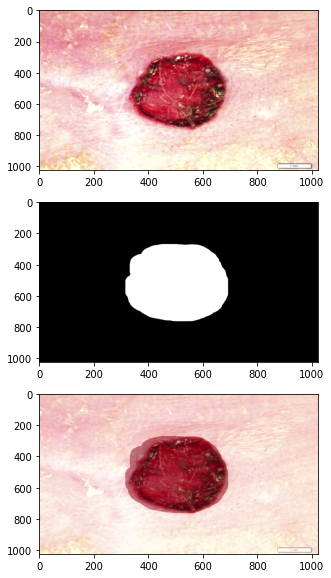

In [ ]:

image_display(train_images, train_masks, 0)

In [ ]:
aug_images = train_images
aug_masks = train_masks

df = train_dataframe(aug_images, aug_masks)
display(df)

,filename,mask
0,/content/drive/MyDrive/Image_dataset/image/353...,/content/drive/MyDrive/Image_dataset/BINARY_MA...
1,/content/drive/MyDrive/Image_dataset/image/241...,/content/drive/MyDrive/Image_dataset/BINARY_MA...
2,/content/drive/MyDrive/Image_dataset/image/485...,/content/drive/MyDrive/Image_dataset/BINARY_MA...
3,/content/drive/MyDrive/Image_dataset/image/641...,/content/drive/MyDrive/Image_dataset/BINARY_MA...
4,/content/drive/MyDrive/Image_dataset/image/634...,/content/drive/MyDrive/Image_dataset/BINARY_MA...
...,...,...
569,/content/drive/MyDrive/Image_dataset/image/319...,/content/drive/MyDrive/Image_dataset/BINARY_MA...
570,/content/drive/MyDrive/Image_dataset/image/386...,/content/drive/MyDrive/Image_dataset/BINARY_MA...
571,/content/drive/MyDrive/Image_dataset/image/539...,/content/drive/MyDrive/Image_dataset/BINARY_MA...
572,/content/drive/MyDrive/Image_dataset/image/416...,/content/drive/MyDrive/Image_dataset/BINARY_MA...


In [ ]:
train_generator_args = dict(rotation_range=0.15,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

# Redefine the input size of the images
width = 256
height = 256
channel = 3

# To visualize the results of generator: set save_to_dir = "your path"
aug_img_dir = None
aug_mask_dir = None
aug_img_prefix = None
aug_mask_prefix = None
aug_format = None

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras import Input

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import Adam


In [ ]:
def dice_coef(y_true, y_pred, smooth = 1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [ ]:
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
def iou(y_true, y_pred, smooth = 1.):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true) + K.sum(y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [ ]:
def TL_unet_model(input_shape):
    # input: input_shape (height, width, channels)
    # return model
    input_shape = input_shape
    base_VGG = VGG16(include_top = False,
                   weights = "imagenet",
                   input_shape = input_shape)

    # freezing all layers in VGG16
    for layer in base_VGG.layers:
        layer.trainable = False

    # the bridge (exclude the last maxpooling layer in VGG16)
    bridge = base_VGG.get_layer("block5_conv3").output
    print(bridge.shape)

    # Decoder now
    up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    print(up1.shape)
    concat_1 = concatenate([up1, base_VGG.get_layer("block4_conv3").output], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat_1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    print(up2.shape)
    concat_2 = concatenate([up2, base_VGG.get_layer("block3_conv3").output], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat_2)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    print(up3.shape)
    concat_3 = concatenate([up3, base_VGG.get_layer("block2_conv2").output], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat_3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    print(up4.shape)
    concat_4 = concatenate([up4, base_VGG.get_layer("block1_conv2").output], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat_4)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    print(conv10.shape)

    model_ = Model(inputs=[base_VGG.input], outputs=[conv10])

    return model_

In [ ]:
input_shape = (height, width, channel)
#output_shape = (256, 256, 1)
K.clear_session()
unet_model = TL_unet_model(input_shape)

58889256/58889256 [==============================] - 0s 0us/step
(None, 16, 16, 512)
(None, 32, 32, 512)
(None, 64, 64, 256)
(None, 128, 128, 128)
(None, 256, 256, 64)
(None, 256, 256, 1)


In [ ]:
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [ ]:
layers = [(layer, layer.name, layer.trainable) for layer in unet_model.layers]
unet_model_df = pd.DataFrame(layers, columns=["Layer Type", "Layer Name", "Layer Trainable"])

display(unet_model_df)

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_1,False
1,<keras.layers.convolutional.conv2d.Conv2D obje...,block1_conv1,False
2,<keras.layers.convolutional.conv2d.Conv2D obje...,block1_conv2,False
3,<keras.layers.pooling.max_pooling2d.MaxPooling...,block1_pool,False
4,<keras.layers.convolutional.conv2d.Conv2D obje...,block2_conv1,False
5,<keras.layers.convolutional.conv2d.Conv2D obje...,block2_conv2,False
6,<keras.layers.pooling.max_pooling2d.MaxPooling...,block2_pool,False
7,<keras.layers.convolutional.conv2d.Conv2D obje...,block3_conv1,False
8,<keras.layers.convolutional.conv2d.Conv2D obje...,block3_conv2,False
9,<keras.layers.convolutional.conv2d.Conv2D obje...,block3_conv3,False


In [ ]:
kf = KFold(n_splits = 5, shuffle=True)
for k, (train_index, test_index) in enumerate(kf.split(df)):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]

print("Training Dataset:")
display(train_df)
print("Validation and Testing Dataset")
display(test_df)

Training Dataset:


,filename,mask
0,/content/drive/MyDrive/Image_dataset/image/353...,/content/drive/MyDrive/Image_dataset/BINARY_MA...
2,/content/drive/MyDrive/Image_dataset/image/485...,/content/drive/MyDrive/Image_dataset/BINARY_MA...
3,/content/drive/MyDrive/Image_dataset/image/641...,/content/drive/MyDrive/Image_dataset/BINARY_MA...
4,/content/drive/MyDrive/Image_dataset/image/634...,/content/drive/MyDrive/Image_dataset/BINARY_MA...
6,/content/drive/MyDrive/Image_dataset/image/335...,/content/drive/MyDrive/Image_dataset/BINARY_MA...
...,...,...
569,/content/drive/MyDrive/Image_dataset/image/319...,/content/drive/MyDrive/Image_dataset/BINARY_MA...
570,/content/drive/MyDrive/Image_dataset/image/386...,/content/drive/MyDrive/Image_dataset/BINARY_MA...
571,/content/drive/MyDrive/Image_dataset/image/539...,/content/drive/MyDrive/Image_dataset/BINARY_MA...
572,/content/drive/MyDrive/Image_dataset/image/416...,/content/drive/MyDrive/Image_dataset/BINARY_MA...


Validation and Testing Dataset


,filename,mask
1,/content/drive/MyDrive/Image_dataset/image/241...,/content/drive/MyDrive/Image_dataset/BINARY_MA...
5,/content/drive/MyDrive/Image_dataset/image/95.png,/content/drive/MyDrive/Image_dataset/BINARY_MA...
8,/content/drive/MyDrive/Image_dataset/image/357...,/content/drive/MyDrive/Image_dataset/BINARY_MA...
13,/content/drive/MyDrive/Image_dataset/image/639...,/content/drive/MyDrive/Image_dataset/BINARY_MA...
16,/content/drive/MyDrive/Image_dataset/image/147...,/content/drive/MyDrive/Image_dataset/BINARY_MA...
...,...,...
544,/content/drive/MyDrive/Image_dataset/image/87.png,/content/drive/MyDrive/Image_dataset/BINARY_MA...
546,/content/drive/MyDrive/Image_dataset/image/392...,/content/drive/MyDrive/Image_dataset/BINARY_MA...
560,/content/drive/MyDrive/Image_dataset/image/340...,/content/drive/MyDrive/Image_dataset/BINARY_MA...
564,/content/drive/MyDrive/Image_dataset/image/511...,/content/drive/MyDrive/Image_dataset/BINARY_MA...


In [ ]:
batch_size = 20
epochs = 50

# Defining the train generator and test generator:
train_gen = train_generator(train_df, batch_size,
                          None,
                          train_generator_args,
                          aug_img_dir, aug_mask_dir,
                          aug_img_prefix, aug_mask_prefix,
                          aug_format,
                          (height, width))

test_gen = train_generator(test_df, batch_size,
                           None,
                           dict(),
                           None, None, None, None, None,
                           (height, width))

# Train the model with `.fit_generator()`
unet_model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                    metrics=[iou, dice_coef, 'binary_accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = unet_model.fit_generator(train_gen,
                                    steps_per_epoch=len(df)//batch_size,
                                    epochs=epochs,
                                    #callbacks=callbacks_list,
                                    validation_data = test_gen,
                                    validation_steps = len(test_df)//batch_size,
                                    verbose=1)

Found 460 validated image filenames.
Found 460 validated image filenames.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: -0.5733 - iou: 0.4052 - dice_coef: 0.5733 - binary_accuracy: 0.4051Found 114 validated image filenames.
Found 114 validated image filenames.
28/28 [==============================] - 231s 8s/step - loss: -0.5733 - iou: 0.4052 - dice_coef: 0.5733 - binary_accuracy: 0.4051 - val_loss: -0.5927 - val_iou: 0.4249 - val_dice_coef: 0.5927 - val_binary_accuracy: 0.4217
Epoch 2/100
28/28 [==============================] - 53s 2s/step - loss: -0.5662 - iou: 0.3972 - dice_coef: 0.5662 - binary_accuracy: 0.4134 - val_loss: -0.6497 - val_iou: 0.4814 - val_dice_coef: 0.6497 - val_binary_accuracy: 0.6207
Epoch 3/100
28/28 [==============================] - 52s 2s/step - loss: -0.6705 - iou: 0.5078 - dice_coef: 0.6705 - binary_accuracy: 0.7523 - val_loss: -0.7113 - val_iou: 0.5575 - val_dice_coef: 0.7113 - val_binary_accuracy: 0.7746
Epoch 4/100
28/28 [==============================] - 53s 2s/step - loss: -0.7408 - iou: 0.5908 - dice_

In [ ]:
import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model,load_model

In [ ]:
def plot_histories(histories):

    # Input: histories obtained from training using fit_generator
    for h, history in enumerate(histories):
        keys = history.history.keys()
        fig, axs = plt.subplots(1, len(keys)//2, figsize = (25, 5))
        fig.suptitle('No. ' + str(h+1) + ' Fold Training Results' , fontsize=30)

        for k, key in enumerate(list(keys)[:len(keys)//2]):
            training = history.history[key]
            validation = history.history['val_' + key]

            epoch_count = range(1, len(training) + 1)

            axs[k].plot(epoch_count, training, 'r--')
            axs[k].plot(epoch_count, validation, 'b-')
            axs[k].legend(['Training ' + key, 'Validation ' + key])

    with open(str(h+1) + '_trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)


In [ ]:
def pred_results_tl(TLmodel, test_df, number_of_img, height, width):
    for i in range(number_of_img):
        index = np.random.randint(0,len(test_df.index))
        print("Testing image", i+1, ":", index)

        img = cv2.imread(test_df['filename'].iloc[index])
        img = cv2.resize(img, (height, width))
        img = img[np.newaxis, :, :, :]
        img = img / 255
        tl_pred = TLmodel.predict(img)

        plt.figure(figsize=(10,10))
        plt.subplot(1,3,1)
        plt.imshow(np.squeeze(img))
        plt.title('Original Image')

        plt.subplot(1,3,2)
        plt.imshow(np.squeeze(cv2.resize(cv2.imread(test_df['mask'].iloc[index]), (height, width))))
        plt.title('Original Mask')

        plt.subplot(1,3,3)
        plt.imshow(np.squeeze(tl_pred) > .5)
        plt.title('Prediction (TL)')

        plt.show()

In [ ]:
unet_model.save('model.h5')

In [ ]:
TLmodel_path = '/content/model.h5'
TLmodel = load_model(TLmodel_path,
                     custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
TLmodel.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                metrics=[iou, dice_coef, 'binary_accuracy'])

evaluate_gen = train_generator(test_df, batch_size,
                               None,
                               dict(),
                               None, None, None, None, None,
                               (height, width))

val_loss, val_iou, val_dice, val_accuracy = TLmodel.evaluate_generator(evaluate_gen,
                                                steps=len(test_df)//batch_size,
                                                verbose=1)

print('Evaluation scores from V-Unet TL model:')
print('Validation loss: ', val_loss)
print('Validation dice coefficient: ', val_dice)
print('Validation iou: ', val_iou)
print('Validation accuracy: ', val_accuracy)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  from ipykernel import kernelapp as app


Found 114 validated image filenames.
Found 114 validated image filenames.
5/5 [==============================] - 6s 1s/step - loss: -0.9052 - iou: 0.8300 - dice_coef: 0.9052 - binary_accuracy: 0.9204
Evaluation scores from V-Unet TL model:
Validation loss:  -0.905185878276825
Validation dice coefficient:  0.905185878276825
Validation iou:  0.8300337791442871
Validation accuracy:  0.9203985333442688


Testing image 1 : 1
1/1 [==============================] - 0s 16ms/step


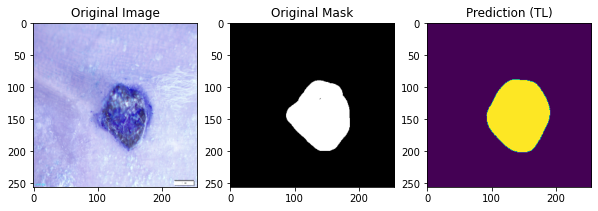

Testing image 2 : 9
1/1 [==============================] - 0s 18ms/step


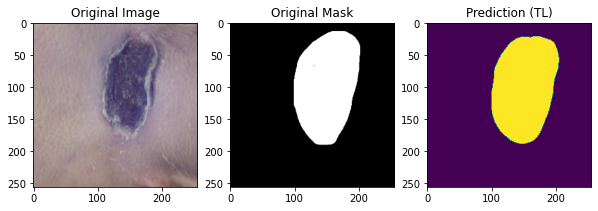

Testing image 3 : 48
1/1 [==============================] - 0s 18ms/step


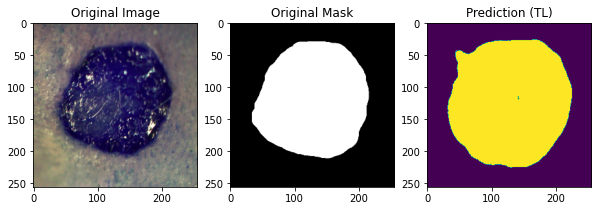

Testing image 4 : 101
1/1 [==============================] - 0s 19ms/step


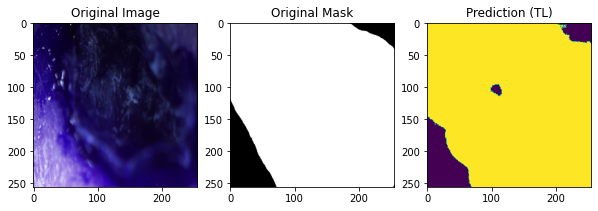

Testing image 5 : 42
1/1 [==============================] - 0s 17ms/step


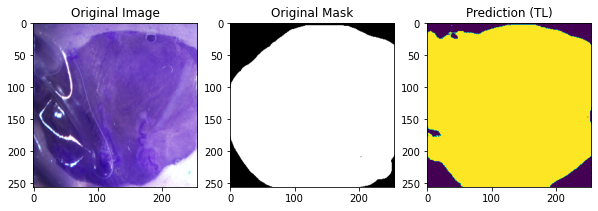

In [ ]:
pred_results_tl(TLmodel, test_df, 5, height, width)